In [18]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import re
import os

In [19]:
qps_stats_folders = [x for x in os.listdir("/data/users/lizhouyu/fbsource/fbcode/torchrec/distributed/benchmark/benchmark_zch") if x.startswith("result_tbsize")]
qps_stats_folders = [x for x in qps_stats_folders if "dlrmv2" in x]
print(qps_stats_folders)
#

['result_tbsize_100000_zch_dlrmv2', 'result_tbsize_100000_nonzch_dlrmv2', 'result_tbsize_100000_nonzch_dlrmv2_bs_128', 'result_tbsize_100000_zch_dlrmv2_bs128', 'result_tbsize_100000_zch_dlrmv2_bs16', 'result_tbsize_100000_nonzch_dlrmv2_bs_16', 'result_tbsize_100000_nonzch_dlrmv2_tb_4', 'result_tbsize_100000_zch_dlrmv2_fullloop', 'result_tbsize_100000_nonzch_dlrmv2_fullloop', 'result_tbsize_100000_nonzch_dlrmv2_noremap']


In [20]:
figure_folder = "/data/users/lizhouyu/fbsource/fbcode/torchrec/distributed/benchmark/benchmark_zch"
os.makedirs(figure_folder, exist_ok=True)

In [21]:
def get_average_qps(qps_stats_file_folder):
    qps_stats_file_path = os.path.join(qps_stats_file_folder, 'qps_metrics.csv')
    df_qps_stats = pd.read_csv(qps_stats_file_path)
    # maintain a dictionary of {feature_name: {batch_idx: num_queries_over_all_ranks_at_batch_idx}}
    rank_qps_dict = {}
    for index, row in df_qps_stats.iterrows():
        batch_idx = row["batch_idx"]
        rank_idx = row["rank"]
        qps = row["qps"]
        if rank_idx not in rank_qps_dict:
            rank_qps_dict[rank_idx] = {}
        rank_qps_dict[rank_idx][batch_idx] = qps
    # get average qps over all ranks
    average_qps_dict = {} # {batch_idx: {"mean": average_qps_at_batch_idx, "min": min_qps_at_batch_idx, "max": max_qps_at_batch_idx}}
    for batch_idx in rank_qps_dict[0]:
        batch_per_rank_qps_list = []
        for rank_idx in rank_qps_dict:
            batch_per_rank_qps_list.append(rank_qps_dict[rank_idx][batch_idx])
        batch_per_rank_qps_list = np.array(batch_per_rank_qps_list)
        average_qps_dict[batch_idx] = {
            "mean": np.mean(batch_per_rank_qps_list),
            "min": np.min(batch_per_rank_qps_list),
            "max": np.max(batch_per_rank_qps_list)
        }
    return average_qps_dict

In [22]:
re_zch_method_name_pattern = re.compile(r"\d+_((non)?zch(.*)?)")
re_table_size_pattern = re.compile(r"result_tbsize_(\d+)")

In [23]:
table_size_zch_method_avetage_qps_dict = {}
for zch_stats_folder in qps_stats_folders:
    print(zch_stats_folder)
    zch_method_name = re_zch_method_name_pattern.search(zch_stats_folder).group(1)
    table_size = int(re_table_size_pattern.search(zch_stats_folder).group(1))
    print(zch_method_name, table_size)
    zch_stats_file_folder = os.path.join("/data/users/lizhouyu/fbsource/fbcode/torchrec/distributed/benchmark/benchmark_zch", zch_stats_folder)
    average_qps_dict = get_average_qps(zch_stats_file_folder)
    if table_size not in table_size_zch_method_avetage_qps_dict:
        table_size_zch_method_avetage_qps_dict[table_size] = {}
    table_size_zch_method_avetage_qps_dict[table_size][zch_method_name] = average_qps_dict

result_tbsize_100000_zch_dlrmv2
zch_dlrmv2 100000
result_tbsize_100000_nonzch_dlrmv2
nonzch_dlrmv2 100000
result_tbsize_100000_nonzch_dlrmv2_bs_128
nonzch_dlrmv2_bs_128 100000
result_tbsize_100000_zch_dlrmv2_bs128
zch_dlrmv2_bs128 100000
result_tbsize_100000_zch_dlrmv2_bs16
zch_dlrmv2_bs16 100000
result_tbsize_100000_nonzch_dlrmv2_bs_16
nonzch_dlrmv2_bs_16 100000
result_tbsize_100000_nonzch_dlrmv2_tb_4
nonzch_dlrmv2_tb_4 100000
result_tbsize_100000_zch_dlrmv2_fullloop
zch_dlrmv2_fullloop 100000
result_tbsize_100000_nonzch_dlrmv2_fullloop
nonzch_dlrmv2_fullloop 100000
result_tbsize_100000_nonzch_dlrmv2_noremap
nonzch_dlrmv2_noremap 100000


Plot collision rate

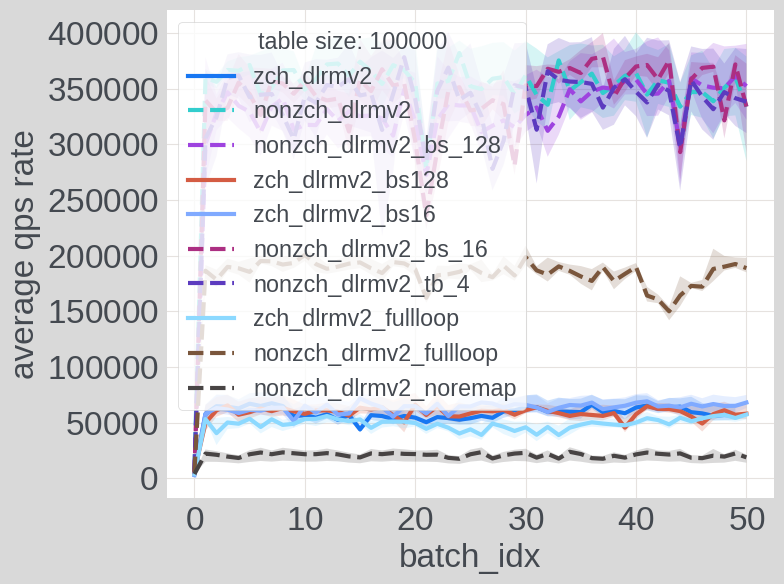

In [24]:
# plot the average ratio of accumulated_collision_count / accumulated_total_count for all the features
# the x-axis is the batch_idx, the y-axis is the ratio
for table_size in table_size_zch_method_avetage_qps_dict:
    fig = plt.figure(figsize=(8, 6))
    font_size = 24
    for zch_method_name in table_size_zch_method_avetage_qps_dict[table_size]:
        x_list = []
        y_list = []
        y_min_list = []
        y_max_list = []
        for batch_idx in table_size_zch_method_avetage_qps_dict[table_size][zch_method_name]:
            x_list.append(batch_idx)
            y_list.append(table_size_zch_method_avetage_qps_dict[table_size][zch_method_name][batch_idx]["mean"])
            y_min_list.append(table_size_zch_method_avetage_qps_dict[table_size][zch_method_name][batch_idx]["min"])
            y_max_list.append(table_size_zch_method_avetage_qps_dict[table_size][zch_method_name][batch_idx]["max"])
        line_style = "--" if "nonzch" in zch_method_name else "-"
        plt.plot(x_list, y_list, label=f"{zch_method_name}", linewidth=3, linestyle=line_style)
        plt.fill_between(x_list, y_min_list, y_max_list, alpha=0.2)
    plt.xlabel("batch_idx", fontsize=font_size)
    plt.ylabel("average qps rate", fontsize=font_size)
    # plt.title("average collision rate vs batch_idx", fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.legend(fontsize=font_size*0.7, title=f"table size: {table_size}", title_fontsize=font_size*0.7)
    # save
    fig_path = os.path.join(figure_folder, f"average_qps_rate_vs_batch_idx_tbsize_{table_size}.png")
    plt.tight_layout()
    fig.savefig(fig_path)
    plt.show()
    plt.close()
# plot the ratio of accumulated_collision_count / accumulated_total_count

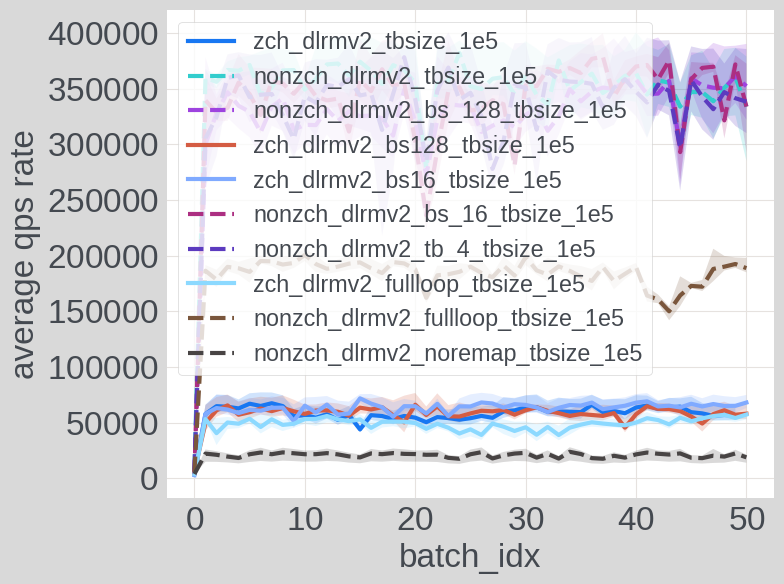

In [25]:
# plot the average ratio of accumulated_collision_count / accumulated_total_count for all the features
# the x-axis is the batch_idx, the y-axis is the ratio
fig = plt.figure(figsize=(8, 6))
font_size = 24
for table_size in table_size_zch_method_avetage_qps_dict:
    # represent table size with 1en
    table_size_scientific = int(np.log10(table_size))
    for zch_method_name in table_size_zch_method_avetage_qps_dict[table_size]:
        x_list = []
        y_list = []
        y_min_list = []
        y_max_list = []
        for batch_idx in table_size_zch_method_avetage_qps_dict[table_size][zch_method_name]:
            x_list.append(batch_idx)
            y_list.append(table_size_zch_method_avetage_qps_dict[table_size][zch_method_name][batch_idx]["mean"])
            y_min_list.append(table_size_zch_method_avetage_qps_dict[table_size][zch_method_name][batch_idx]["min"])
            y_max_list.append(table_size_zch_method_avetage_qps_dict[table_size][zch_method_name][batch_idx]["max"])
        line_style = "--" if "nonzch" in zch_method_name else "-"
        plt.plot(x_list, y_list, label=f"{zch_method_name}_tbsize_1e{table_size_scientific}", linewidth=3, linestyle=line_style)
        plt.fill_between(x_list, y_min_list, y_max_list, alpha=0.2)
plt.xlabel("batch_idx", fontsize=font_size)
plt.ylabel("average qps rate", fontsize=font_size)
# plt.title("average collision rate vs batch_idx", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size*0.7)
# save
fig_path = os.path.join(figure_folder, f"average_qps_rate_vs_batch_idx.png")
plt.tight_layout()
fig.savefig(fig_path)
plt.show()
plt.close()
# plot the ratio of accumulated_collision_count / accumulated_total_count